    problem                     search  expansions  tests  new nodes  \
0         1              Breadth First          43     56        180   
1         1         Breadth First Tree        1458   1459       5960   
2         1          Depth First Graph          12     13         48   
3         1              Depth Limited         101    271        414   
4         1               Uniform Cost          55     57        224   
5         1    Recursive BestFirst h_1        4229   4230      17029   
6         1  Greedy BestFirstGraph h_1           7      9         28   
7         1                     A* h_1          55     57        224   
8         1  A* h_ignore_preconditions          41     43        170   
9         1           A* h_pg_levelsum          11     13         50   
10        2              Breadth First        3343   4609      30509   
11        2         Breadth First Tree           0      0          0   
12        2          Depth First Graph        1669   1670      1

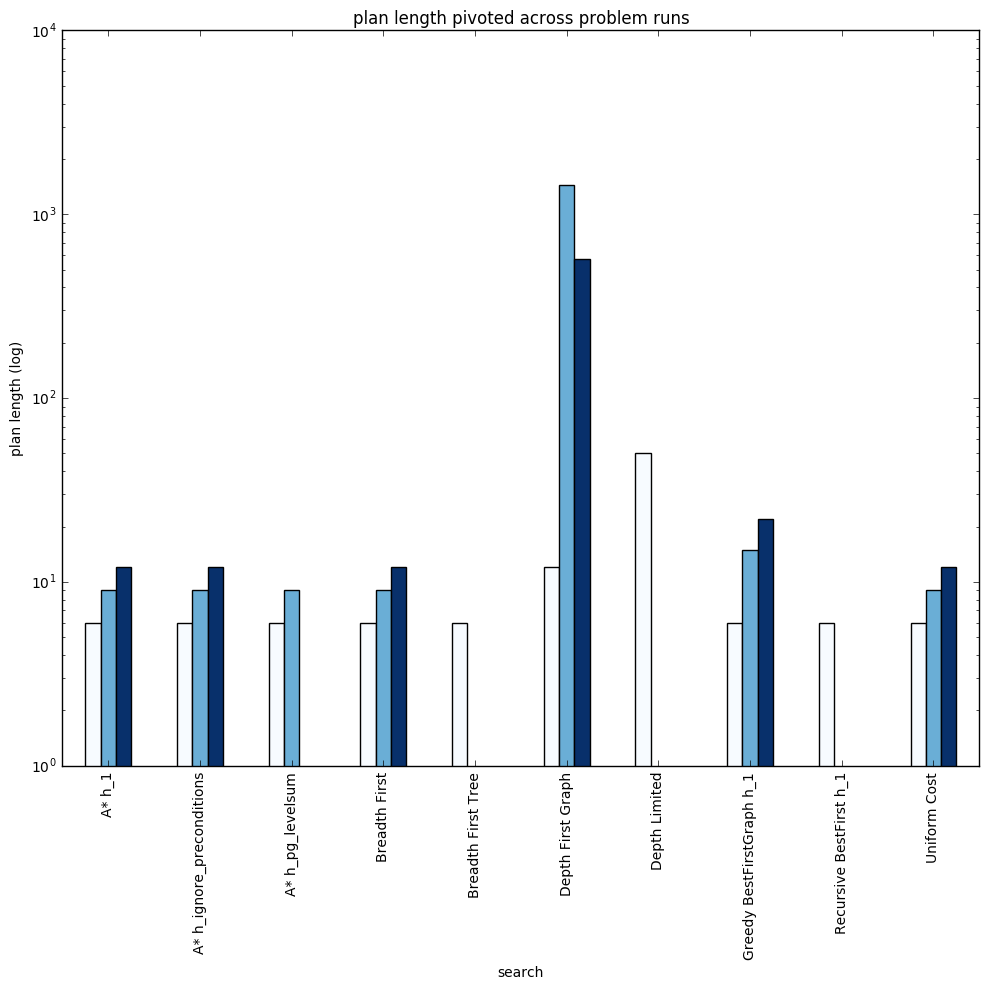

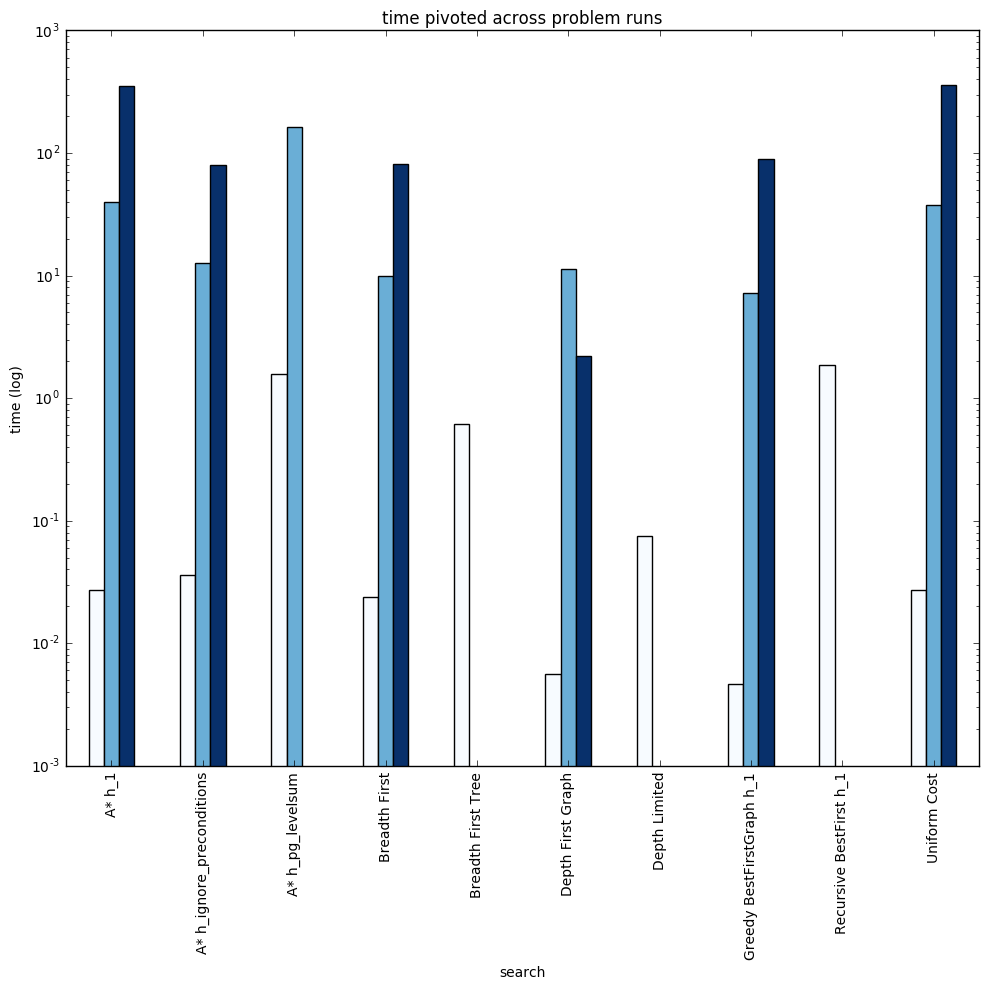

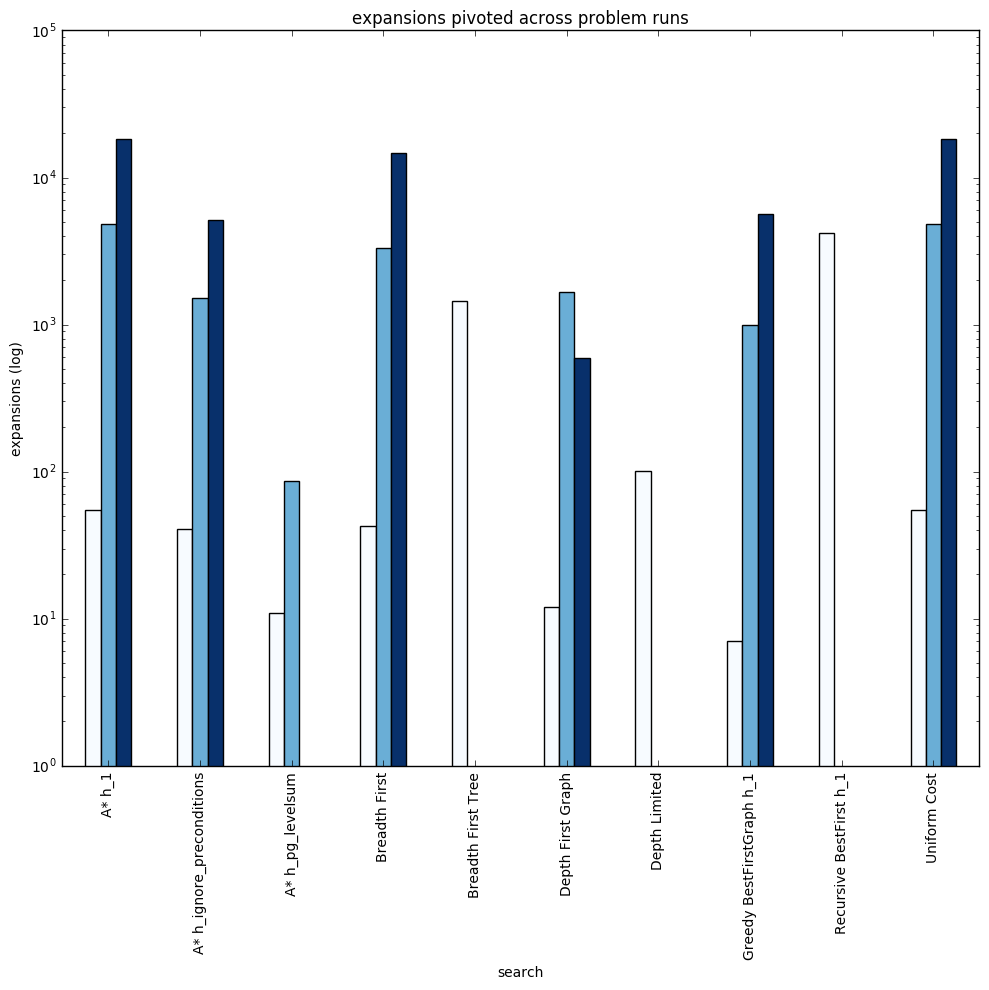

In [18]:
import matplotlib.pyplot as plt
import pandas as pd


search_map = {
    1: 'Breadth First',
    2: 'Breadth First Tree',
    3: 'Depth First Graph',
    4: 'Depth Limited',
    5: 'Uniform Cost',
    6: 'Recursive BestFirst h_1',
    7: 'Greedy BestFirstGraph h_1',
    8: 'A* h_1',
    9: 'A* h_ignore_preconditions',
    10: 'A* h_pg_levelsum'
}



df=pd.read_csv('uninformed.csv')
df['search'] = df['search'].map(search_map)
print(df)

labels = []
idx=1

for y in ['plan length', 'time', 'expansions']:
    a = df.pivot(index='search', columns='problem', values=y).plot(kind='bar', logy=True, legend=False, figsize=(10,10), colormap='Blues')
    a.set_ylabel(y+" (log)")
    a.set_title(y+" pivoted across problem runs")
    fig = a.get_figure()
    plt.tight_layout()
    fig.savefig("img_{}.png".format(y.replace(' ','_')))
plt.show()